In [25]:
import seaborn as sns
import os
import torch
import random
import numpy as np
import pandas as pd
from EDA import *
from transformers import BertTokenizer, XLNetModel, XLNetTokenizer, XLNetForSequenceClassification, RobertaTokenizer, RobertaForSequenceClassification
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
df = pd.read_csv(r'./news.csv')
df

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL
...,...,...,...,...
6330,4490,State Department says it can't find emails fro...,The State Department told the Republican Natio...,REAL
6331,8062,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,FAKE
6332,8622,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,FAKE
6333,4021,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",REAL


In [4]:
title = list(df['title'])
text = list(df['text'])
news = []
for i in range(len(title)):
    news.append(title[i] + '.\n' + text[i])
labels = list(df['label'])
labels = [0 if i == 'FAKE' else 1 for i in labels]
data = (news, labels)

In [5]:
from sklearn.model_selection import train_test_split

news_train, news_test, labels_train, labels_test = train_test_split(news, labels, test_size = 0.2)
train_data = (news_train, labels_train)
test_data = (news_test, labels_test)

print('train size: ', len(train_data[0]))
print('test size: ', len(test_data[0]))

train size:  5068
test size:  1267


In [6]:
# shuffle
state = np.random.get_state()
np.random.shuffle(train_data[0])
np.random.set_state(state)
np.random.shuffle(train_data[1])


state1 = np.random.get_state()
np.random.shuffle(test_data[0])
np.random.set_state(state1)
np.random.shuffle(test_data[1])

In [7]:
# tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
# print(len(tokenizer.vocab))

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [8]:
train_input_ids = []
train_attention_masks = []

n=5068

for sentence in train_data[0][:n]:

    encoded = tokenizer.encode_plus(
        text=sentence,  # the sentence to be encoded
        add_special_tokens=True,  # Add [CLS] and [SEP]
        max_length = 128,  # maximum length of a sentence
        pad_to_max_length = True,
#         padding='max_length',  # Add [PAD]s
        return_attention_mask = True,  # Generate the attention mask
        return_tensors = 'pt',  # ask the function to return PyTorch tensors
    )

    train_input_ids.append(encoded['input_ids'])
#     print(encoded['input_ids'])
    

    train_attention_masks.append(encoded['attention_mask'])

    
train_input_ids = torch.cat(train_input_ids)
train_attention_masks = torch.cat(train_attention_masks)
train_labels = torch.tensor(train_data[1][:n])
    

# # Get the input IDs and attention mask in tensor format

print('Original: ', train_data[0][0])
print('Token IDs:', train_input_ids[0])
print(train_labels[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/root/miniconda3/envs/myconda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2073: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  Trump’s Camp Manager DESTROYS Hillary By Pointing Out 1 Thing We All Missed.
Trump’s Camp Manager DESTROYS Hillary By Pointing Out 1 Thing We All Missed Posted on October 30, 2016 by Amanda Shea in Politics Share This Fox News Host (left), Trump’s Campaign Manager Kellyanne Conway (right) 
From the moment the FBI announced they’re investigating Hillary Clinton again, her ship of supporters quickly became lighter with people bailing out to protect themselves from being associated with her as a criminal. Donald Trump’s campaign couldn’t have asked for better vindication that the witch could soon be incarcerated, but the Republican candidate’s campaign manager just put the final nail in Clinton’s coffin. 
In the wake of this latest development that could save Western civilization, Kellyanne Conway went on Fox News to discuss it, but she delivered more than viewers were expecting. In a statement that didn’t just decimate Hillary’s campaign, she brought the entire Clinton family 

In [9]:
from torch.utils.data import TensorDataset, random_split


dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size


train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

4,561 training samples
  507 validation samples


In [10]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler



batch_size = 16

train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), 
            batch_size = batch_size
        )


validation_dataloader = DataLoader(
            val_dataset, 
            sampler = SequentialSampler(val_dataset), 
            batch_size = batch_size 
        )

In [11]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = RobertaForSequenceClassification.from_pretrained(
    "roberta-base", 
    num_labels = 2, 
                   
    output_attentions = False, .
    output_hidden_states = False, 
    return_dict=False
)


model.cuda()

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

In [12]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8
                )

from transformers import get_linear_schedule_with_warmup


epochs = 3

total_steps = len(train_dataloader) * epochs


scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

In [13]:
import numpy as np


def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    elapsed_rounded = int(round((elapsed)))
    
  
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [14]:
torch.cuda.empty_cache()

In [15]:
import random
import numpy as np


seed_val = 42
batch_size = 32
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)


training_stats = []


total_t0 = time.time()

for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

   
    t0 = time.time()


    total_train_loss = 0

    
    model.train()


    for step, batch in enumerate(train_dataloader):

        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

       
        optimizer.zero_grad()        

        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

  
        total_train_loss += loss.item()


        loss.backward()

       
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

     
        optimizer.step()

       
        scheduler.step()


    avg_train_loss = total_train_loss / len(train_dataloader)            
    

    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
  

    print("")
    print("Running Validation...")

    t0 = time.time()


    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
       
        with torch.no_grad():        
            output = model(b_input_ids, 
                                   token_type_ids=None,
                           attention_mask=b_input_mask)
            

        #total_eval_loss += loss.item()
        logits = output[0]

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()


        total_eval_accuracy += flat_accuracy(logits, label_ids)
        


    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

 
    #avg_val_loss = total_eval_loss / len(validation_dataloader)
    
   
    validation_time = format_time(time.time() - t0)
    
    #print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))


    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            #'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...
  Batch    40  of    286.    Elapsed: 0:00:05.
  Batch    80  of    286.    Elapsed: 0:00:11.
  Batch   120  of    286.    Elapsed: 0:00:15.
  Batch   160  of    286.    Elapsed: 0:00:21.
  Batch   200  of    286.    Elapsed: 0:00:26.
  Batch   240  of    286.    Elapsed: 0:00:31.
  Batch   280  of    286.    Elapsed: 0:00:36.

  Average training loss: 0.12
  Training epcoh took: 0:00:37

Running Validation...
  Accuracy: 0.99
  Validation took: 0:00:01

======== Epoch 2 / 3 ========
Training...
  Batch    40  of    286.    Elapsed: 0:00:05.
  Batch    80  of    286.    Elapsed: 0:00:10.
  Batch   120  of    286.    Elapsed: 0:00:15.
  Batch   160  of    286.    Elapsed: 0:00:20.
  Batch   200  of    286.    Elapsed: 0:00:25.
  Batch   240  of    286.    Elapsed: 0:00:30.
  Batch   280  of    286.    Elapsed: 0:00:35.

  Average training loss: 0.02
  Training epcoh took: 0:00:36

Running Validation...
  Accuracy: 1.00
  Validation took: 0:00:0

In [16]:
import pandas as pd


pd.set_option('precision', 2)

df_stats = pd.DataFrame(data=training_stats)


df_stats = df_stats.set_index('epoch')


df_stats



,Training Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,
1,1.22e-01,0.99,0:00:37,0:00:01
2,1.83e-02,1.00,0:00:36,0:00:01
3,4.45e-03,1.00,0:00:36,0:00:01


In [17]:
# 将数据集分完词后存储到列表中
test_input_ids = []
test_attention_masks = []

n = 1267
for sentence in test_data[0][:n]:
    encoded = tokenizer.encode_plus(
        text=sentence,  # the sentence to be encoded
        add_special_tokens=True,  # Add [CLS] and [SEP]
        max_length = 128,  # maximum length of a sentence
        pad_to_max_length = True,
#         padding='max_length',  # Add [PAD]s
        return_attention_mask = True,  # Generate the attention mask
        return_tensors = 'pt',  # ask the function to return PyTorch tensors
    )
  

    test_input_ids.append(encoded['input_ids'])
#     print(encoded['input_ids'])
  
  
    test_attention_masks.append(encoded['attention_mask'])


test_input_ids = torch.cat(test_input_ids)
test_attention_masks = torch.cat(test_attention_masks)
test_labels = torch.tensor(test_data[1][:n])

batch_size = 32  


prediction_data = TensorDataset(test_input_ids, test_attention_masks, test_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

/root/miniconda3/envs/myconda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2073: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [18]:


print('Predicting labels for {:,} test sentences...'.format(len(test_input_ids)))

model.eval()

# Tracking variables 
predictions , true_labels = [], []


for batch in prediction_dataloader:

    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    # 不需要计算梯度
    with torch.no_grad():
      # 前向传播，获取预测结果
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

    logits = outputs[0]


    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    #total_eval_accuracy += flat_accuracy(logits, label_ids)



    predictions.append(logits)
    true_labels.append(label_ids)
#avg_val_accuracy = flat_accuracy(predictions, true_labels)    
#avg_val_accuracy = total_eval_accuracy / len(prediction_dataloader)
#print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
print('    DONE.')

Predicting labels for 1,267 test sentences...
    DONE.


In [19]:
print('Positive samples: %d of %d (%.2f%%)' % (sum(test_data[1]), len(test_data[1]), (sum(test_data[1]) / len(test_data[1]) * 100.0)))


Positive samples: 615 of 1267 (48.54%)


In [21]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

pred_labels_i = []
# For each input batch...
for i in range(len(true_labels)):
    pred_labels_i += list(np.argmax(predictions[i], axis=1).flatten())

    
true_labels_list = []
for i in test_labels:
    true_labels_list.append(i.item())

accuracy_score(pred_labels_i, true_labels_list)

0.9913180741910024

Classification Report:
              precision    recall  f1-score   support

           1     0.9840    0.9984    0.9911       615
           0     0.9984    0.9847    0.9915       652

    accuracy                         0.9913      1267
   macro avg     0.9912    0.9915    0.9913      1267
weighted avg     0.9914    0.9913    0.9913      1267



[Text(0, 0.5, 'POS'), Text(0, 1.5, 'NEG')]

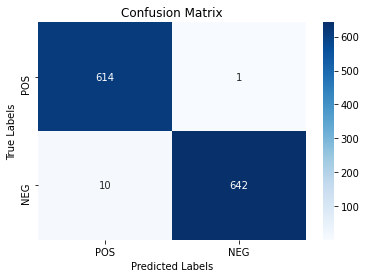

In [26]:
import matplotlib.pyplot as plt
print('Classification Report:') 
print(classification_report(true_labels_list, pred_labels_i, labels=[1,0], digits=4)) 

cm = confusion_matrix(true_labels_list, pred_labels_i, labels=[1,0]) 
ax= plt.subplot() 
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d") 
ax.set_title('Confusion Matrix') 
ax.set_xlabel('Predicted Labels') 
ax.set_ylabel('True Labels') 
ax.xaxis.set_ticklabels(['POS', 'NEG']) 
ax.yaxis.set_ticklabels(['POS', 'NEG']) 